## Check Python Version

In [1]:
from platform import python_version
import sys

Check your current distribution of Python. Note that forest is built using Python 3.8

In [2]:
print(python_version())
print(sys.executable)

3.10.1
/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10


Install git, pip, and forest using the lines below in a command-line shell 

In [ ]:
# conda install git pip
# pip install git+git://github.com/onnela-lab/forest.git@main

## Download Sample Data


In [ ]:
import wget
import zipfile
import os

This cell will download a zip file (~740MB of data). This will take up to an hour or more, depending on the speed of your internet connection. 

In [ ]:

source_url = "https://zenodo.org/record/1188879/files/data.zip?download=1"
dest_dir = os.getcwd()
zip_fpath = wget.download(source_url, out = dest_dir)

This cell will unzip the file downloaded in the previous block into a folder called data. The subfolders in this directory contain data produced by the Beiwe app.

In [ ]:
# unzip in the same directory as the downloaded zip
with zipfile.ZipFile(zip_fpath, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

This cell removes the downloaded zip file to save space on your computer

In [ ]:
 os.remove(zip_fpath)

This cell verifies that the process of downloading and unzipping the data is complete.

In [ ]:
# check the unzipped dir exists 
data_dir = "data"
if os.path.isdir(data_dir):
    print("Data Successfully Downloaded and Unzipped")

## Process Data using Forest 
- Using the Forest library developed by the Onnela lab, we compute daily GPS and communication summary statistics

First, we generate the GPS-related summary statistics by using the **gps_stats_main** function under the **traj2stat.py** in the Jasmine tree of Forest. 

If this is working correctly, you will see something like: 
User: tcqrulfj
Read in the csv files ...
Collapse data within 10 second intervals ...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...
Selecting basis vectors ...
Imputing missing trajectories ...
Tidying up the trajectories...
Calculating the daily summary stats...

In [19]:
import forest

data_dir = "data/onnela_lab_ios_test1"
output_dir = "gps_output"
tz_str = "America/New_York"
option = "daily"
save_traj = True 

forest.jasmine.traj2stats.gps_stats_main(data_dir, output_dir, tz_str, option, save_traj)

User: tcqrulfj
Read in the csv files ...
Collapse data within 10 second intervals ...
Extract flights and pauses ...
Infer unclassified windows ...
Merge consecutive pauses and bridge gaps ...
Selecting basis vectors ...
Imputing missing trajectories ...
Tidying up the trajectories...
Calculating the daily summary stats...


Second, we compute the call and text-based summary statistics by using the **log_stats_main** function under the **log_stats.py** in the Willow tree of Forest  

If this is working correctly, you will see something like:

(need to add)

In [16]:
import forest

data_dir = "data/onnela_lab_gps_testing"
output_dir = "comm_output"
tz_str = "America/New_York"
option = "daily"

forest.willow.log_stats.log_stats_main(data_dir, output_dir, tz_str, option)


User: 6b38vskd
User 6b38vskd : texts data are not collected.
An error occured when processing the data.


The outputs of **gps_stats_main** and **log_stats_main** are generated with respect to each suject in the study folder. The following code is  used to concatenate these files into a single csv for GPS and communication summaries separately.

In [12]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta  
import math
from functools import reduce

# Path to subdirectory
direc = os.getcwd()
data_dir = os.path.join(direc,"gps_output")


# initialize dataframe list
df_list = []

# loop through all directories - select folder
for subdir, dirs, files in os.walk(data_dir):
    
    # loop through files in list
    for file in files:
        # obtain subject study_id 
        file_dir = os.path.join(data_dir,file)
        print(file_dir)
        subject_id = os.path.basename(file_dir)[:-4]
        if file[-4:] == ".csv":# only read in csv files
            temp_df = pd.read_csv(file_dir)
            temp_df.insert(loc=0, column="Date", value=pd.to_datetime(temp_df[['day', 'month', 'year']]))
            temp_df.insert(loc=0, column='Beiwe_ID', value=subject_id)
            df_list.append(temp_df)
                
# concatenate dataframes within list --> Final Data for trajectories
response_data = pd.concat(df_list, axis=0).reset_index()
response_data = response_data.drop(['index','day', 'month', 'year'], axis=1)

# print few few observations
print(response_data.head())

# Write results to CSV 
response_filename = 'gps_summary.csv'

path_resp = os.path.join(direc, response_filename)    

# write to csv
response_data.to_csv(path_resp, index=False)

/Volumes/SanDisk/onnela_lab/forest_notebooks/gps_output/6b38vskd.csv
/Volumes/SanDisk/onnela_lab/forest_notebooks/gps_output/.DS_Store
/Volumes/SanDisk/onnela_lab/forest_notebooks/gps_output/all_memory_dict.pkl
/Volumes/SanDisk/onnela_lab/forest_notebooks/gps_output/all_BV_set.pkl
/Volumes/SanDisk/onnela_lab/forest_notebooks/gps_output/6b38vskd.csv
   Beiwe_ID       Date  obs_duration    obs_day  obs_night  home_time  \
0  6b38vskd 2016-01-26      8.897222   3.202778   5.694444   1.494444   
1  6b38vskd 2016-01-27     23.026389  10.475000  12.551389   0.000000   
2  6b38vskd 2016-01-28     21.131944   8.658333  12.473611   0.000000   
3  6b38vskd 2016-01-29     23.386111  11.475000  11.911111   0.000000   
4  6b38vskd 2016-01-30     23.769444  11.869444  11.900000   0.000000   

   dist_traveled  max_dist_home    radius  diameter  num_sig_places   entropy  \
0         18.403       6.174510  2.298162  6.965317               3  0.901055   
1         11.003       2.051055  0.587464  2.624

In [13]:
# (use study_id and timestamp)
# Path to subdirectory
direc = os.getcwd()
data_dir = os.path.join(direc,"comm_output")


# initialize dataframe list
df_list = []

# loop through all directories - select folder
for subdir, dirs, files in os.walk(data_dir):
    
    # loop through files in list
    for file in files:
        # obtain patient study_id 
        file_dir = os.path.join(data_dir,file)
        print(file_dir)
        subject_id = os.path.basename(file_dir)[:-4]
        if file[-4:] == ".csv":
            temp_df = pd.read_csv(file_dir)
            temp_df.insert(loc=0, column="Date", value=pd.to_datetime(temp_df[['day', 'month', 'year']]))
            temp_df.insert(loc=0, column='Beiwe_ID', value=subject_id)
            df_list.append(temp_df)
                
# concatenate dataframes within list --> Final Data for trajectories
response_data = pd.concat(df_list, axis=0).reset_index()
response_data = response_data.drop(['index','day', 'month', 'year'], axis=1)

# print few few observations
print(response_data.head())

# Write results to CSV 
response_filename = 'comm_summary.csv'

path_resp = os.path.join(direc, response_filename)    

# write to csv
response_data.to_csv(path_resp, index=False)

ValueError: No objects to concatenate

## Plot Data

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd

direc = os.getcwd()
response_filename = 'gps_summary.csv'
path_resp = os.path.join(direc, response_filename)    

# read data
response_data = pd.read_csv(path_resp)

## Make sure the data is sorted according to date
response_data.sort_values('Date', inplace = True)
response_data.reset_index(drop = True, inplace = True)

def time_series_plot(var_to_plot, num_x_ticks = 4):
    if len(response_data['Beiwe_ID'].unique()) > 1: ## more than one user to plot
        plt.plot(response_data.Date, response_data[var_to_plot], c=response_data['Beiwe_ID'].astype('category').cat.codes)
    else:
        plt.plot(response_data.Date, response_data[var_to_plot]) #just one user
    title = f"Time Series Plot of {var_to_plot}"
    plt.title(title)
    
    ## get evenly indices
    tick_indices = [(i * (response_data.shape[0] - 1)) // (num_x_ticks - 1) for i in range(num_x_ticks) ]
    plt.xticks(response_data.Date[tick_indices])
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SanDisk/onnela_lab/forest_repo/forest/tutorials/gps_summary.csv'

You can now create time series plots as done below

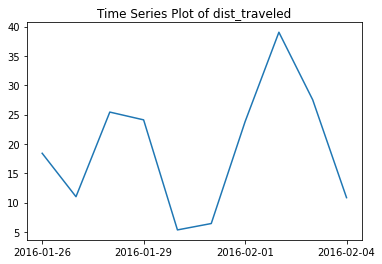

In [8]:
time_series_plot('dist_traveled')

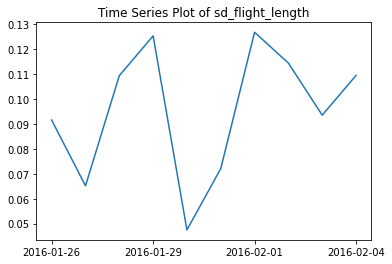

In [9]:
time_series_plot('sd_flight_length')

In [2]:
response_data.columns

NameError: name 'response_data' is not defined